#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset

In [2]:
# create an instance of the training split of the FashionMNIST dataset
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=ToTensor(), target_transform=lambda x: torch.Tensor([x]).int())
# now create an instance of the test split
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=ToTensor(), target_transform=lambda x: torch.Tensor([x]).int())
# for our purposes we can combine the 60k training and 10k testing samples
dataset = ConcatDataset([dataset_train, dataset_valid])
# display some information on the dataset
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


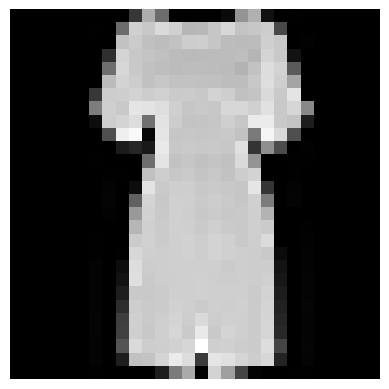

The image shows an instance of Dress.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1,16,1,bias=False) # 1x1 Convolution für Identity
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))  # This will resize any input to have spatial dimensions of 6x6.
        self.conv1 = nn.Conv2d(1, 6, 3,stride=2,bias=False)
        self.conv2 = nn.Conv2d(6, 16, 3,stride=2,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        y = self.conv0(x) # 1x1 conv auf x angewandt
        y = self.bn2(y) #normalisiert .classes
        x = F.relu(self.bn1(self.conv1(x))) #erster Schritt im ResBlock
        x = self.conv2(x) #Zweiter Schritt im Resblock
        x = self.bn2(x) #Zweiter Schritt im Resblock
        y = self.adaptive_pool(y)
        x = torch.add(x,y) #Addition des zweiten Schritts des Resblocks mit y (identity)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [6]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
net = Net().to(device)
#net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Using device: cuda


In [7]:
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
for epoch in range(100):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.squeeze(1).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(img_tensors)
        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        # print statsample_img = istics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2:.3f}')
            running_loss = 0.0

print('Finished Training')

5it [00:00,  9.87it/s]

[1,     2] loss: 2.321
[1,     4] loss: 2.316


7it [00:00,  9.94it/s]

[1,     6] loss: 2.312


9it [00:01,  9.97it/s]

[1,     8] loss: 2.306


11it [00:01,  9.99it/s]

[1,    10] loss: 2.299


13it [00:01, 10.00it/s]

[1,    12] loss: 2.293


15it [00:01,  9.98it/s]

[1,    14] loss: 2.287


17it [00:01,  9.93it/s]

[1,    16] loss: 2.277


19it [00:02,  9.96it/s]

[1,    18] loss: 2.266


21it [00:02,  9.96it/s]

[1,    20] loss: 2.255


23it [00:02,  9.93it/s]

[1,    22] loss: 2.244


25it [00:02,  8.72it/s]

[1,    24] loss: 2.241


26it [00:02,  8.76it/s]

[1,    26] loss: 2.227


30it [00:03,  9.34it/s]

[1,    28] loss: 2.221
[1,    30] loss: 2.209



3it [00:00,  7.48it/s]

[2,     2] loss: 2.200


5it [00:00,  8.56it/s]

[2,     4] loss: 2.193


7it [00:00,  9.07it/s]

[2,     6] loss: 2.177


9it [00:01,  9.39it/s]

[2,     8] loss: 2.164
[2,    10] loss: 2.152


13it [00:01,  9.75it/s]

[2,    12] loss: 2.143
[2,    14] loss: 2.136


17it [00:01,  9.91it/s]

[2,    16] loss: 2.119
[2,    18] loss: 2.112


21it [00:02,  9.98it/s]

[2,    20] loss: 2.099
[2,    22] loss: 2.090


25it [00:02, 10.00it/s]

[2,    24] loss: 2.075
[2,    26] loss: 2.057


30it [00:03,  9.58it/s]

[2,    28] loss: 2.049
[2,    30] loss: 2.034



3it [00:00,  7.32it/s]

[3,     2] loss: 2.014


5it [00:00,  8.37it/s]

[3,     4] loss: 2.005
[3,     6] loss: 1.990


9it [00:01,  9.19it/s]

[3,     8] loss: 1.983


11it [00:01,  9.34it/s]

[3,    10] loss: 1.957


13it [00:01,  9.49it/s]

[3,    12] loss: 1.939
[3,    14] loss: 1.933


17it [00:01,  9.61it/s]

[3,    16] loss: 1.905


19it [00:02,  9.63it/s]

[3,    18] loss: 1.883


21it [00:02,  9.64it/s]

[3,    20] loss: 1.880


23it [00:02,  9.65it/s]

[3,    22] loss: 1.848


25it [00:02,  9.67it/s]

[3,    24] loss: 1.828


27it [00:02,  9.64it/s]

[3,    26] loss: 1.818
[3,    28] loss: 1.795


30it [00:03,  9.55it/s]

[3,    30] loss: 1.766



1it [00:00,  4.32it/s]

[4,     2] loss: 1.767


3it [00:00,  7.22it/s]

[4,     4] loss: 1.738


5it [00:00,  8.13it/s]

[4,     6] loss: 1.719


7it [00:00,  8.63it/s]

[4,     8] loss: 1.703


9it [00:01,  8.91it/s]

[4,    10] loss: 1.657


11it [00:01,  9.10it/s]

[4,    12] loss: 1.668


13it [00:01,  9.24it/s]

[4,    14] loss: 1.658


15it [00:01,  9.31it/s]

[4,    16] loss: 1.620


17it [00:01,  9.35it/s]

[4,    18] loss: 1.612


19it [00:02,  9.38it/s]

[4,    20] loss: 1.599


21it [00:02,  9.42it/s]

[4,    22] loss: 1.562


23it [00:02,  9.42it/s]

[4,    24] loss: 1.547


25it [00:02,  9.45it/s]

[4,    26] loss: 1.543


29it [00:03,  9.53it/s]

[4,    28] loss: 1.521
[4,    30] loss: 1.487


30it [00:03,  9.34it/s]
3it [00:00,  7.54it/s]

[5,     2] loss: 1.479
[5,     4] loss: 1.448


7it [00:00,  9.20it/s]

[5,     6] loss: 1.457
[5,     8] loss: 1.440


11it [00:01,  9.74it/s]

[5,    10] loss: 1.423
[5,    12] loss: 1.409


15it [00:01,  9.90it/s]

[5,    14] loss: 1.389
[5,    16] loss: 1.393


19it [00:02, 10.00it/s]

[5,    18] loss: 1.352
[5,    20] loss: 1.355


23it [00:02, 10.09it/s]

[5,    22] loss: 1.331
[5,    24] loss: 1.308


27it [00:02, 10.10it/s]

[5,    26] loss: 1.281
[5,    28] loss: 1.284


30it [00:03,  9.95it/s]

[5,    30] loss: 1.264



3it [00:00,  7.46it/s]

[6,     2] loss: 1.272


5it [00:00,  8.47it/s]

[6,     4] loss: 1.255


7it [00:00,  9.02it/s]

[6,     6] loss: 1.241
[6,     8] loss: 1.226


11it [00:01,  9.55it/s]

[6,    10] loss: 1.214
[6,    12] loss: 1.174


15it [00:01,  9.79it/s]

[6,    14] loss: 1.193
[6,    16] loss: 1.176


19it [00:02,  9.89it/s]

[6,    18] loss: 1.158
[6,    20] loss: 1.143


23it [00:02,  9.86it/s]

[6,    22] loss: 1.128
[6,    24] loss: 1.144


27it [00:02,  9.74it/s]

[6,    26] loss: 1.119
[6,    28] loss: 1.103


30it [00:03,  9.72it/s]

[6,    30] loss: 1.125



3it [00:00,  7.58it/s]

[7,     2] loss: 1.083


5it [00:00,  8.60it/s]

[7,     4] loss: 1.067


7it [00:00,  9.17it/s]

[7,     6] loss: 1.063


9it [00:01,  9.49it/s]

[7,     8] loss: 1.063


11it [00:01,  9.69it/s]

[7,    10] loss: 1.035


13it [00:01,  9.87it/s]

[7,    12] loss: 1.050


15it [00:01,  9.88it/s]

[7,    14] loss: 1.024


17it [00:01,  9.91it/s]

[7,    16] loss: 1.017


19it [00:02,  9.94it/s]

[7,    18] loss: 1.027


21it [00:02,  9.97it/s]

[7,    20] loss: 1.032


23it [00:02, 10.01it/s]

[7,    22] loss: 0.997


25it [00:02, 10.01it/s]

[7,    24] loss: 0.988


27it [00:02, 10.05it/s]

[7,    26] loss: 0.999
[7,    28] loss: 0.993


30it [00:03,  9.91it/s]

[7,    30] loss: 0.986



3it [00:00,  7.59it/s]

[8,     2] loss: 0.972


5it [00:00,  8.65it/s]

[8,     4] loss: 0.959


7it [00:00,  9.19it/s]

[8,     6] loss: 0.958


9it [00:01,  9.50it/s]

[8,     8] loss: 0.940


11it [00:01,  9.70it/s]

[8,    10] loss: 0.942


13it [00:01,  9.80it/s]

[8,    12] loss: 0.919


15it [00:01,  9.88it/s]

[8,    14] loss: 0.915


17it [00:01,  9.92it/s]

[8,    16] loss: 0.904


19it [00:02,  9.97it/s]

[8,    18] loss: 0.911


21it [00:02,  9.93it/s]

[8,    20] loss: 0.924


23it [00:02,  9.94it/s]

[8,    22] loss: 0.919


25it [00:02,  9.88it/s]

[8,    24] loss: 0.891


26it [00:02,  9.65it/s]

[8,    26] loss: 0.897
[8,    28] loss: 0.892


30it [00:03,  9.86it/s]

[8,    30] loss: 0.894



3it [00:00,  7.51it/s]

[9,     2] loss: 0.877


5it [00:00,  8.50it/s]

[9,     4] loss: 0.882


7it [00:00,  8.98it/s]

[9,     6] loss: 0.869


9it [00:01,  9.24it/s]

[9,     8] loss: 0.856


11it [00:01,  9.39it/s]

[9,    10] loss: 0.862


13it [00:01,  9.33it/s]

[9,    12] loss: 0.869


15it [00:01,  9.45it/s]

[9,    14] loss: 0.829


17it [00:01,  9.47it/s]

[9,    16] loss: 0.840


19it [00:02,  9.53it/s]

[9,    18] loss: 0.828


21it [00:02,  9.33it/s]

[9,    20] loss: 0.827


23it [00:02,  9.46it/s]

[9,    22] loss: 0.842


25it [00:02,  9.58it/s]

[9,    24] loss: 0.831


27it [00:02,  9.55it/s]

[9,    26] loss: 0.822


30it [00:03,  9.49it/s]

[9,    28] loss: 0.840
[9,    30] loss: 0.847



1it [00:00,  3.60it/s]

[10,     2] loss: 0.810


3it [00:00,  6.44it/s]

[10,     4] loss: 0.793


5it [00:00,  7.62it/s]

[10,     6] loss: 0.801


7it [00:00,  8.21it/s]

[10,     8] loss: 0.815


9it [00:01,  8.58it/s]

[10,    10] loss: 0.817


11it [00:01,  8.84it/s]

[10,    12] loss: 0.793


13it [00:01,  9.01it/s]

[10,    14] loss: 0.804


15it [00:01,  9.11it/s]

[10,    16] loss: 0.786


17it [00:02,  9.17it/s]

[10,    18] loss: 0.795


19it [00:02,  9.14it/s]

[10,    20] loss: 0.795


21it [00:02,  9.26it/s]

[10,    22] loss: 0.762


23it [00:02,  9.26it/s]

[10,    24] loss: 0.766


25it [00:02,  9.22it/s]

[10,    26] loss: 0.795


27it [00:03,  9.22it/s]

[10,    28] loss: 0.767


30it [00:03,  9.03it/s]

[10,    30] loss: 0.775



3it [00:00,  7.30it/s]

[11,     2] loss: 0.773


5it [00:00,  8.35it/s]

[11,     4] loss: 0.760


7it [00:00,  8.78it/s]

[11,     6] loss: 0.755
[11,     8] loss: 0.783


11it [00:01,  9.22it/s]

[11,    10] loss: 0.770


13it [00:01,  9.34it/s]

[11,    12] loss: 0.728
[11,    14] loss: 0.736


15it [00:01,  9.37it/s]

[11,    16] loss: 0.757


19it [00:02,  9.46it/s]

[11,    18] loss: 0.738
[11,    20] loss: 0.759


21it [00:02,  9.44it/s]

[11,    22] loss: 0.745


25it [00:02,  9.50it/s]

[11,    24] loss: 0.737


27it [00:02,  9.56it/s]

[11,    26] loss: 0.740
[11,    28] loss: 0.719


30it [00:03,  9.43it/s]

[11,    30] loss: 0.733



3it [00:00,  7.61it/s]

[12,     2] loss: 0.731
[12,     4] loss: 0.724


7it [00:00,  9.19it/s]

[12,     6] loss: 0.704
[12,     8] loss: 0.744


11it [00:01,  9.69it/s]

[12,    10] loss: 0.729
[12,    12] loss: 0.736


15it [00:01,  9.79it/s]

[12,    14] loss: 0.719
[12,    16] loss: 0.724


19it [00:02,  9.80it/s]

[12,    18] loss: 0.706
[12,    20] loss: 0.713


23it [00:02,  9.77it/s]

[12,    22] loss: 0.710


25it [00:02,  9.85it/s]

[12,    24] loss: 0.715
[12,    26] loss: 0.698


29it [00:03,  9.92it/s]

[12,    28] loss: 0.699
[12,    30] loss: 0.676


30it [00:03,  9.80it/s]
3it [00:00,  7.37it/s]

[13,     2] loss: 0.694
[13,     4] loss: 0.686


7it [00:00,  8.82it/s]

[13,     6] loss: 0.685
[13,     8] loss: 0.719


9it [00:01,  9.07it/s]

[13,    10] loss: 0.718


11it [00:01,  9.22it/s]

[13,    12] loss: 0.686


13it [00:01,  9.29it/s]

[13,    14] loss: 0.707


15it [00:01,  9.35it/s]

[13,    16] loss: 0.695


17it [00:01,  9.42it/s]

[13,    18] loss: 0.682


21it [00:02,  9.56it/s]

[13,    20] loss: 0.688
[13,    22] loss: 0.689


25it [00:02,  9.77it/s]

[13,    24] loss: 0.681


27it [00:02,  9.81it/s]

[13,    26] loss: 0.671
[13,    28] loss: 0.677


30it [00:03,  9.55it/s]

[13,    30] loss: 0.648



3it [00:00,  7.29it/s]

[14,     2] loss: 0.665


5it [00:00,  8.30it/s]

[14,     4] loss: 0.683


7it [00:00,  8.88it/s]

[14,     6] loss: 0.662


9it [00:01,  9.16it/s]

[14,     8] loss: 0.672


11it [00:01,  9.39it/s]

[14,    10] loss: 0.675


13it [00:01,  9.55it/s]

[14,    12] loss: 0.666


15it [00:01,  9.61it/s]

[14,    14] loss: 0.681


17it [00:01,  9.62it/s]

[14,    16] loss: 0.660


19it [00:02,  9.73it/s]

[14,    18] loss: 0.681


21it [00:02,  9.77it/s]

[14,    20] loss: 0.675


23it [00:02,  9.80it/s]

[14,    22] loss: 0.665


25it [00:02,  9.85it/s]

[14,    24] loss: 0.659


27it [00:02,  9.81it/s]

[14,    26] loss: 0.661
[14,    28] loss: 0.661


30it [00:03,  9.65it/s]

[14,    30] loss: 0.648



3it [00:00,  7.53it/s]

[15,     2] loss: 0.679
[15,     4] loss: 0.647


7it [00:00,  8.48it/s]

[15,     6] loss: 0.633
[15,     8] loss: 0.648


11it [00:01,  9.28it/s]

[15,    10] loss: 0.656
[15,    12] loss: 0.645


15it [00:01,  9.62it/s]

[15,    14] loss: 0.639
[15,    16] loss: 0.659


19it [00:02,  9.73it/s]

[15,    18] loss: 0.650


21it [00:02,  9.74it/s]

[15,    20] loss: 0.642
[15,    22] loss: 0.643


25it [00:02,  9.72it/s]

[15,    24] loss: 0.649


27it [00:02,  9.62it/s]

[15,    26] loss: 0.652
[15,    28] loss: 0.649


30it [00:03,  9.50it/s]

[15,    30] loss: 0.634



1it [00:00,  4.25it/s]

[16,     2] loss: 0.632


3it [00:00,  7.20it/s]

[16,     4] loss: 0.657


5it [00:00,  8.13it/s]

[16,     6] loss: 0.646


9it [00:01,  8.98it/s]

[16,     8] loss: 0.637
[16,    10] loss: 0.641


11it [00:01,  9.16it/s]

[16,    12] loss: 0.638


13it [00:01,  9.20it/s]

[16,    14] loss: 0.628


15it [00:01,  9.21it/s]

[16,    16] loss: 0.617


17it [00:01,  9.27it/s]

[16,    18] loss: 0.623


19it [00:02,  9.36it/s]

[16,    20] loss: 0.638


23it [00:02,  9.50it/s]

[16,    22] loss: 0.651


25it [00:02,  9.57it/s]

[16,    24] loss: 0.626


27it [00:02,  9.60it/s]

[16,    26] loss: 0.650
[16,    28] loss: 0.617


30it [00:03,  9.39it/s]

[16,    30] loss: 0.587



1it [00:00,  4.29it/s]

[17,     2] loss: 0.624


5it [00:00,  8.25it/s]

[17,     4] loss: 0.624
[17,     6] loss: 0.640


9it [00:01,  9.07it/s]

[17,     8] loss: 0.624


11it [00:01,  9.30it/s]

[17,    10] loss: 0.618


13it [00:01,  9.43it/s]

[17,    12] loss: 0.609


15it [00:01,  9.54it/s]

[17,    14] loss: 0.608


17it [00:01,  9.58it/s]

[17,    16] loss: 0.624


19it [00:02,  9.63it/s]

[17,    18] loss: 0.619


21it [00:02,  9.64it/s]

[17,    20] loss: 0.608


23it [00:02,  9.67it/s]

[17,    22] loss: 0.629


25it [00:02,  9.68it/s]

[17,    24] loss: 0.607
[17,    26] loss: 0.620


29it [00:03,  9.64it/s]

[17,    28] loss: 0.620


30it [00:03,  9.51it/s]

[17,    30] loss: 0.607



3it [00:00,  7.54it/s]

[18,     2] loss: 0.635
[18,     4] loss: 0.592


7it [00:00,  9.12it/s]

[18,     6] loss: 0.626


9it [00:01,  9.40it/s]

[18,     8] loss: 0.625


11it [00:01,  9.57it/s]

[18,    10] loss: 0.603


13it [00:01,  9.63it/s]

[18,    12] loss: 0.604


15it [00:01,  9.64it/s]

[18,    14] loss: 0.638


17it [00:01,  9.63it/s]

[18,    16] loss: 0.592


19it [00:02,  9.68it/s]

[18,    18] loss: 0.603


21it [00:02,  9.68it/s]

[18,    20] loss: 0.591


23it [00:02,  9.73it/s]

[18,    22] loss: 0.614


25it [00:02,  9.65it/s]

[18,    24] loss: 0.585


27it [00:02,  9.66it/s]

[18,    26] loss: 0.587


30it [00:03,  9.65it/s]

[18,    28] loss: 0.610
[18,    30] loss: 0.589



3it [00:00,  7.36it/s]

[19,     2] loss: 0.603


5it [00:00,  8.42it/s]

[19,     4] loss: 0.606
[19,     6] loss: 0.608


9it [00:01,  9.08it/s]

[19,     8] loss: 0.595


11it [00:01,  9.28it/s]

[19,    10] loss: 0.599


13it [00:01,  9.40it/s]

[19,    12] loss: 0.598
[19,    14] loss: 0.598


17it [00:01,  9.53it/s]

[19,    16] loss: 0.589


19it [00:02,  9.62it/s]

[19,    18] loss: 0.623
[19,    20] loss: 0.584


23it [00:02,  9.73it/s]

[19,    22] loss: 0.583
[19,    24] loss: 0.584


27it [00:02,  9.81it/s]

[19,    26] loss: 0.599
[19,    28] loss: 0.573


30it [00:03,  9.58it/s]

[19,    30] loss: 0.579



3it [00:00,  7.33it/s]

[20,     2] loss: 0.566
[20,     4] loss: 0.588


7it [00:00,  9.05it/s]

[20,     6] loss: 0.590
[20,     8] loss: 0.581


11it [00:01,  9.41it/s]

[20,    10] loss: 0.593
[20,    12] loss: 0.585


15it [00:01,  9.52it/s]

[20,    14] loss: 0.593


17it [00:01,  9.56it/s]

[20,    16] loss: 0.555
[20,    18] loss: 0.595


19it [00:02,  9.57it/s]

[20,    20] loss: 0.583


21it [00:02,  9.56it/s]

[20,    22] loss: 0.588


23it [00:02,  9.57it/s]

[20,    24] loss: 0.581


27it [00:02,  9.58it/s]

[20,    26] loss: 0.590
[20,    28] loss: 0.608


30it [00:03,  9.53it/s]

[20,    30] loss: 0.573



3it [00:00,  7.40it/s]

[21,     2] loss: 0.574


5it [00:00,  8.48it/s]

[21,     4] loss: 0.604
[21,     6] loss: 0.579


9it [00:01,  9.32it/s]

[21,     8] loss: 0.571


11it [00:01,  9.48it/s]

[21,    10] loss: 0.580


13it [00:01,  9.59it/s]

[21,    12] loss: 0.562


15it [00:01,  9.66it/s]

[21,    14] loss: 0.589


17it [00:01,  9.72it/s]

[21,    16] loss: 0.579


19it [00:02,  9.61it/s]

[21,    18] loss: 0.572


21it [00:02,  9.67it/s]

[21,    20] loss: 0.557


23it [00:02,  9.68it/s]

[21,    22] loss: 0.575


25it [00:02,  9.71it/s]

[21,    24] loss: 0.578


27it [00:02,  9.69it/s]

[21,    26] loss: 0.573


30it [00:03,  9.63it/s]

[21,    28] loss: 0.580
[21,    30] loss: 0.557



3it [00:00,  7.35it/s]

[22,     2] loss: 0.582


5it [00:00,  8.41it/s]

[22,     4] loss: 0.541


7it [00:00,  8.88it/s]

[22,     6] loss: 0.565


9it [00:01,  9.17it/s]

[22,     8] loss: 0.558


11it [00:01,  9.38it/s]

[22,    10] loss: 0.568


13it [00:01,  9.50it/s]

[22,    12] loss: 0.581


15it [00:01,  9.56it/s]

[22,    14] loss: 0.558


17it [00:01,  9.61it/s]

[22,    16] loss: 0.580


19it [00:02,  9.65it/s]

[22,    18] loss: 0.578


21it [00:02,  9.69it/s]

[22,    20] loss: 0.547


23it [00:02,  9.69it/s]

[22,    22] loss: 0.561
[22,    24] loss: 0.581


27it [00:02,  9.36it/s]

[22,    26] loss: 0.584
[22,    28] loss: 0.552


30it [00:03,  9.48it/s]

[22,    30] loss: 0.579



3it [00:00,  7.46it/s]

[23,     2] loss: 0.563


5it [00:00,  8.54it/s]

[23,     4] loss: 0.549


7it [00:00,  9.06it/s]

[23,     6] loss: 0.576


9it [00:01,  9.33it/s]

[23,     8] loss: 0.537


11it [00:01,  9.51it/s]

[23,    10] loss: 0.554


13it [00:01,  9.63it/s]

[23,    12] loss: 0.559


15it [00:01,  9.69it/s]

[23,    14] loss: 0.574


17it [00:01,  9.75it/s]

[23,    16] loss: 0.562


19it [00:02,  9.77it/s]

[23,    18] loss: 0.560


21it [00:02,  9.79it/s]

[23,    20] loss: 0.560


23it [00:02,  9.81it/s]

[23,    22] loss: 0.560


25it [00:02,  9.83it/s]

[23,    24] loss: 0.553


27it [00:02,  9.85it/s]

[23,    26] loss: 0.562
[23,    28] loss: 0.558


30it [00:03,  9.73it/s]

[23,    30] loss: 0.546



3it [00:00,  7.38it/s]

[24,     2] loss: 0.551


5it [00:00,  8.44it/s]

[24,     4] loss: 0.574
[24,     6] loss: 0.545


9it [00:01,  9.25it/s]

[24,     8] loss: 0.552
[24,    10] loss: 0.541


13it [00:01,  9.56it/s]

[24,    12] loss: 0.559
[24,    14] loss: 0.544


17it [00:01,  9.67it/s]

[24,    16] loss: 0.563
[24,    18] loss: 0.536


21it [00:02,  9.71it/s]

[24,    20] loss: 0.552
[24,    22] loss: 0.557


25it [00:02,  9.69it/s]

[24,    24] loss: 0.554
[24,    26] loss: 0.555


27it [00:02,  8.47it/s]

[24,    28] loss: 0.550


30it [00:03,  9.30it/s]

[24,    30] loss: 0.537



3it [00:00,  7.63it/s]

[25,     2] loss: 0.571
[25,     4] loss: 0.552


7it [00:00,  9.26it/s]

[25,     6] loss: 0.552
[25,     8] loss: 0.560


11it [00:01,  9.73it/s]

[25,    10] loss: 0.541
[25,    12] loss: 0.538


15it [00:01,  9.92it/s]

[25,    14] loss: 0.555
[25,    16] loss: 0.521


19it [00:02, 10.01it/s]

[25,    18] loss: 0.550
[25,    20] loss: 0.541


23it [00:02, 10.08it/s]

[25,    22] loss: 0.525
[25,    24] loss: 0.530


27it [00:02, 10.11it/s]

[25,    26] loss: 0.542
[25,    28] loss: 0.542


30it [00:03,  9.94it/s]

[25,    30] loss: 0.573



3it [00:00,  7.39it/s]

[26,     2] loss: 0.532
[26,     4] loss: 0.546


7it [00:00,  8.90it/s]

[26,     6] loss: 0.542


9it [00:01,  9.14it/s]

[26,     8] loss: 0.540


11it [00:01,  9.24it/s]

[26,    10] loss: 0.532


13it [00:01,  9.38it/s]

[26,    12] loss: 0.538


15it [00:01,  9.46it/s]

[26,    14] loss: 0.536


17it [00:01,  9.51it/s]

[26,    16] loss: 0.513


19it [00:02,  9.51it/s]

[26,    18] loss: 0.545
[26,    20] loss: 0.549


23it [00:02,  9.57it/s]

[26,    22] loss: 0.531


25it [00:02,  9.61it/s]

[26,    24] loss: 0.544
[26,    26] loss: 0.541


29it [00:03,  8.95it/s]

[26,    28] loss: 0.550
[26,    30] loss: 0.527


30it [00:03,  9.28it/s]
3it [00:00,  7.43it/s]

[27,     2] loss: 0.533


5it [00:00,  8.45it/s]

[27,     4] loss: 0.544
[27,     6] loss: 0.528


7it [00:00,  8.71it/s]

[27,     8] loss: 0.529


11it [00:01,  9.06it/s]

[27,    10] loss: 0.517


13it [00:01,  9.25it/s]

[27,    12] loss: 0.526
[27,    14] loss: 0.512


17it [00:01,  9.48it/s]

[27,    16] loss: 0.544


19it [00:02,  9.56it/s]

[27,    18] loss: 0.526


21it [00:02,  9.60it/s]

[27,    20] loss: 0.557


23it [00:02,  9.66it/s]

[27,    22] loss: 0.545
[27,    24] loss: 0.541


27it [00:02,  9.71it/s]

[27,    26] loss: 0.524
[27,    28] loss: 0.527


30it [00:03,  9.49it/s]

[27,    30] loss: 0.524



3it [00:00,  7.42it/s]

[28,     2] loss: 0.546


5it [00:00,  8.45it/s]

[28,     4] loss: 0.518


7it [00:00,  8.99it/s]

[28,     6] loss: 0.519


9it [00:01,  9.28it/s]

[28,     8] loss: 0.549


11it [00:01,  9.49it/s]

[28,    10] loss: 0.523


13it [00:01,  9.63it/s]

[28,    12] loss: 0.504


15it [00:01,  9.62it/s]

[28,    14] loss: 0.531


17it [00:01,  9.68it/s]

[28,    16] loss: 0.523
[28,    18] loss: 0.542


21it [00:02,  9.78it/s]

[28,    20] loss: 0.528
[28,    22] loss: 0.499


25it [00:02,  9.84it/s]

[28,    24] loss: 0.531
[28,    26] loss: 0.525


29it [00:03,  9.09it/s]

[28,    28] loss: 0.514
[28,    30] loss: 0.543


30it [00:03,  9.44it/s]
3it [00:00,  7.44it/s]

[29,     2] loss: 0.535


5it [00:00,  8.48it/s]

[29,     4] loss: 0.526


7it [00:00,  9.00it/s]

[29,     6] loss: 0.512
[29,     8] loss: 0.521


11it [00:01,  9.44it/s]

[29,    10] loss: 0.528


13it [00:01,  9.54it/s]

[29,    12] loss: 0.528


15it [00:01,  9.63it/s]

[29,    14] loss: 0.522
[29,    16] loss: 0.523


19it [00:02,  9.77it/s]

[29,    18] loss: 0.516
[29,    20] loss: 0.512


23it [00:02,  9.90it/s]

[29,    22] loss: 0.529
[29,    24] loss: 0.525


27it [00:02,  9.96it/s]

[29,    26] loss: 0.503
[29,    28] loss: 0.518


30it [00:03,  9.74it/s]

[29,    30] loss: 0.512



3it [00:00,  7.63it/s]

[30,     2] loss: 0.517


5it [00:00,  8.66it/s]

[30,     4] loss: 0.530


7it [00:00,  9.11it/s]

[30,     6] loss: 0.518


9it [00:01,  9.36it/s]

[30,     8] loss: 0.514


11it [00:01,  9.44it/s]

[30,    10] loss: 0.508


13it [00:01,  9.56it/s]

[30,    12] loss: 0.524


15it [00:01,  9.56it/s]

[30,    14] loss: 0.504


17it [00:01,  9.36it/s]

[30,    16] loss: 0.499


19it [00:02,  9.50it/s]

[30,    18] loss: 0.526


21it [00:02,  9.60it/s]

[30,    20] loss: 0.504


23it [00:02,  9.57it/s]

[30,    22] loss: 0.543


25it [00:02,  9.64it/s]

[30,    24] loss: 0.514
[30,    26] loss: 0.517


30it [00:03,  9.30it/s]

[30,    28] loss: 0.509
[30,    30] loss: 0.514



1it [00:00,  4.31it/s]

[31,     2] loss: 0.515


3it [00:00,  7.26it/s]

[31,     4] loss: 0.511


7it [00:00,  8.84it/s]

[31,     6] loss: 0.513


9it [00:01,  9.13it/s]

[31,     8] loss: 0.512
[31,    10] loss: 0.513


13it [00:01,  9.38it/s]

[31,    12] loss: 0.503
[31,    14] loss: 0.499


15it [00:01,  9.41it/s]

[31,    16] loss: 0.500


19it [00:02,  9.49it/s]

[31,    18] loss: 0.508


21it [00:02,  9.54it/s]

[31,    20] loss: 0.524


23it [00:02,  9.61it/s]

[31,    22] loss: 0.519


25it [00:02,  9.65it/s]

[31,    24] loss: 0.523
[31,    26] loss: 0.509


27it [00:02,  9.50it/s]

[31,    28] loss: 0.519


30it [00:03,  9.45it/s]

[31,    30] loss: 0.491



3it [00:00,  7.35it/s]

[32,     2] loss: 0.515


5it [00:00,  8.38it/s]

[32,     4] loss: 0.512


7it [00:00,  8.87it/s]

[32,     6] loss: 0.500


9it [00:01,  9.15it/s]

[32,     8] loss: 0.506
[32,    10] loss: 0.510


13it [00:01,  9.40it/s]

[32,    12] loss: 0.500
[32,    14] loss: 0.508


17it [00:01,  9.48it/s]

[32,    16] loss: 0.494
[32,    18] loss: 0.494


21it [00:02,  9.54it/s]

[32,    20] loss: 0.499
[32,    22] loss: 0.490


23it [00:02,  9.57it/s]

[32,    24] loss: 0.524


25it [00:02,  9.59it/s]

[32,    26] loss: 0.518


27it [00:02,  9.47it/s]

[32,    28] loss: 0.522


30it [00:03,  9.46it/s]

[32,    30] loss: 0.517



3it [00:00,  7.46it/s]

[33,     2] loss: 0.504
[33,     4] loss: 0.526


7it [00:00,  9.11it/s]

[33,     6] loss: 0.492
[33,     8] loss: 0.516


11it [00:01,  9.65it/s]

[33,    10] loss: 0.508
[33,    12] loss: 0.488


15it [00:01,  9.84it/s]

[33,    14] loss: 0.500
[33,    16] loss: 0.502


19it [00:02,  9.96it/s]

[33,    18] loss: 0.488
[33,    20] loss: 0.517


23it [00:02, 10.02it/s]

[33,    22] loss: 0.504
[33,    24] loss: 0.510


27it [00:02, 10.06it/s]

[33,    26] loss: 0.490
[33,    28] loss: 0.497


30it [00:03,  9.86it/s]

[33,    30] loss: 0.472



3it [00:00,  7.40it/s]

[34,     2] loss: 0.527
[34,     4] loss: 0.476


7it [00:00,  9.13it/s]

[34,     6] loss: 0.522
[34,     8] loss: 0.487


11it [00:01,  9.65it/s]

[34,    10] loss: 0.502
[34,    12] loss: 0.509


15it [00:01,  9.85it/s]

[34,    14] loss: 0.490


17it [00:01,  9.88it/s]

[34,    16] loss: 0.480


19it [00:02,  9.86it/s]

[34,    18] loss: 0.497


21it [00:02,  9.90it/s]

[34,    20] loss: 0.483


23it [00:02,  9.93it/s]

[34,    22] loss: 0.483


25it [00:02,  9.97it/s]

[34,    24] loss: 0.503


27it [00:02,  9.99it/s]

[34,    26] loss: 0.516
[34,    28] loss: 0.500


30it [00:03,  9.83it/s]

[34,    30] loss: 0.495



3it [00:00,  7.45it/s]

[35,     2] loss: 0.483
[35,     4] loss: 0.497


7it [00:00,  9.05it/s]

[35,     6] loss: 0.479


9it [00:01,  9.37it/s]

[35,     8] loss: 0.524


11it [00:01,  9.47it/s]

[35,    10] loss: 0.493


13it [00:01,  9.64it/s]

[35,    12] loss: 0.502
[35,    14] loss: 0.503


17it [00:01,  9.86it/s]

[35,    16] loss: 0.476
[35,    18] loss: 0.506


21it [00:02,  9.96it/s]

[35,    20] loss: 0.495
[35,    22] loss: 0.490


25it [00:02, 10.03it/s]

[35,    24] loss: 0.494


27it [00:02, 10.03it/s]

[35,    26] loss: 0.496
[35,    28] loss: 0.487


30it [00:03,  9.82it/s]

[35,    30] loss: 0.485



3it [00:00,  7.41it/s]

[36,     2] loss: 0.501
[36,     4] loss: 0.497


7it [00:00,  9.05it/s]

[36,     6] loss: 0.480
[36,     8] loss: 0.482


9it [00:01,  9.32it/s]

[36,    10] loss: 0.484


13it [00:01,  9.56it/s]

[36,    12] loss: 0.484
[36,    14] loss: 0.506


17it [00:01,  9.76it/s]

[36,    16] loss: 0.487
[36,    18] loss: 0.498


21it [00:02,  9.79it/s]

[36,    20] loss: 0.487
[36,    22] loss: 0.482


25it [00:02,  9.87it/s]

[36,    24] loss: 0.480


27it [00:02,  9.88it/s]

[36,    26] loss: 0.505
[36,    28] loss: 0.502


30it [00:03,  9.72it/s]

[36,    30] loss: 0.472



3it [00:00,  7.62it/s]

[37,     2] loss: 0.515
[37,     4] loss: 0.474


7it [00:00,  9.27it/s]

[37,     6] loss: 0.483
[37,     8] loss: 0.497


11it [00:01,  9.72it/s]

[37,    10] loss: 0.502
[37,    12] loss: 0.479


15it [00:01,  9.88it/s]

[37,    14] loss: 0.489
[37,    16] loss: 0.459


19it [00:02,  9.99it/s]

[37,    18] loss: 0.484
[37,    20] loss: 0.475


23it [00:02, 10.03it/s]

[37,    22] loss: 0.490
[37,    24] loss: 0.479


27it [00:02, 10.05it/s]

[37,    26] loss: 0.508
[37,    28] loss: 0.479


30it [00:03,  9.93it/s]

[37,    30] loss: 0.478



3it [00:00,  7.48it/s]

[38,     2] loss: 0.468


5it [00:00,  8.46it/s]

[38,     4] loss: 0.495


7it [00:00,  8.90it/s]

[38,     6] loss: 0.477


9it [00:01,  9.25it/s]

[38,     8] loss: 0.486


11it [00:01,  9.45it/s]

[38,    10] loss: 0.498


13it [00:01,  9.52it/s]

[38,    12] loss: 0.498


15it [00:01,  9.59it/s]

[38,    14] loss: 0.502


17it [00:01,  9.60it/s]

[38,    16] loss: 0.506


19it [00:02,  9.69it/s]

[38,    18] loss: 0.482


21it [00:02,  9.62it/s]

[38,    20] loss: 0.461


23it [00:02,  9.69it/s]

[38,    22] loss: 0.463


25it [00:02,  9.69it/s]

[38,    24] loss: 0.492


27it [00:02,  9.63it/s]

[38,    26] loss: 0.477


30it [00:03,  9.59it/s]

[38,    28] loss: 0.467
[38,    30] loss: 0.483



1it [00:00,  4.35it/s]

[39,     2] loss: 0.491


5it [00:00,  8.33it/s]

[39,     4] loss: 0.478
[39,     6] loss: 0.476


9it [00:01,  9.15it/s]

[39,     8] loss: 0.471
[39,    10] loss: 0.482


11it [00:01,  9.14it/s]

[39,    12] loss: 0.473


13it [00:01,  9.14it/s]

[39,    14] loss: 0.466


15it [00:01,  9.20it/s]

[39,    16] loss: 0.462


19it [00:02,  9.38it/s]

[39,    18] loss: 0.489
[39,    20] loss: 0.492


23it [00:02,  9.51it/s]

[39,    22] loss: 0.510
[39,    24] loss: 0.471


27it [00:02,  9.72it/s]

[39,    26] loss: 0.485
[39,    28] loss: 0.475


30it [00:03,  9.45it/s]

[39,    30] loss: 0.483



3it [00:00,  7.44it/s]

[40,     2] loss: 0.483
[40,     4] loss: 0.479


7it [00:00,  9.04it/s]

[40,     6] loss: 0.475
[40,     8] loss: 0.455


11it [00:01,  9.49it/s]

[40,    10] loss: 0.490


13it [00:01,  9.65it/s]

[40,    12] loss: 0.475
[40,    14] loss: 0.472


17it [00:01,  9.64it/s]

[40,    16] loss: 0.478
[40,    18] loss: 0.499


21it [00:02,  9.80it/s]

[40,    20] loss: 0.485
[40,    22] loss: 0.467


25it [00:02,  9.72it/s]

[40,    24] loss: 0.476


27it [00:02,  9.68it/s]

[40,    26] loss: 0.466


29it [00:03,  9.81it/s]

[40,    28] loss: 0.486
[40,    30] loss: 0.462


30it [00:03,  9.66it/s]
3it [00:00,  7.32it/s]

[41,     2] loss: 0.498


5it [00:00,  8.36it/s]

[41,     4] loss: 0.477


7it [00:00,  8.95it/s]

[41,     6] loss: 0.461


9it [00:01,  9.20it/s]

[41,     8] loss: 0.467


11it [00:01,  9.40it/s]

[41,    10] loss: 0.487


13it [00:01,  9.45it/s]

[41,    12] loss: 0.466


15it [00:01,  9.57it/s]

[41,    14] loss: 0.468


17it [00:01,  9.67it/s]

[41,    16] loss: 0.489
[41,    18] loss: 0.487


21it [00:02,  9.71it/s]

[41,    20] loss: 0.478


23it [00:02,  9.74it/s]

[41,    22] loss: 0.475


25it [00:02,  9.74it/s]

[41,    24] loss: 0.463


27it [00:02,  9.66it/s]

[41,    26] loss: 0.450


30it [00:03,  9.57it/s]

[41,    28] loss: 0.485
[41,    30] loss: 0.431



3it [00:00,  7.61it/s]

[42,     2] loss: 0.461


5it [00:00,  8.53it/s]

[42,     4] loss: 0.478


7it [00:00,  9.03it/s]

[42,     6] loss: 0.463


9it [00:01,  9.33it/s]

[42,     8] loss: 0.485
[42,    10] loss: 0.476


13it [00:01,  9.59it/s]

[42,    12] loss: 0.470


15it [00:01,  9.63it/s]

[42,    14] loss: 0.489


17it [00:01,  9.72it/s]

[42,    16] loss: 0.466
[42,    18] loss: 0.456


21it [00:02,  9.74it/s]

[42,    20] loss: 0.468


23it [00:02,  9.76it/s]

[42,    22] loss: 0.462


25it [00:02,  9.80it/s]

[42,    24] loss: 0.469


27it [00:02,  9.73it/s]

[42,    26] loss: 0.479
[42,    28] loss: 0.465


30it [00:03,  9.70it/s]

[42,    30] loss: 0.474



1it [00:00,  4.32it/s]

[43,     2] loss: 0.479


3it [00:00,  7.22it/s]

[43,     4] loss: 0.479


5it [00:00,  8.21it/s]

[43,     6] loss: 0.478


9it [00:01,  9.10it/s]

[43,     8] loss: 0.467


11it [00:01,  9.33it/s]

[43,    10] loss: 0.470


13it [00:01,  9.41it/s]

[43,    12] loss: 0.462


15it [00:01,  9.47it/s]

[43,    14] loss: 0.454


17it [00:01,  9.43it/s]

[43,    16] loss: 0.452


19it [00:02,  9.50it/s]

[43,    18] loss: 0.457


21it [00:02,  9.53it/s]

[43,    20] loss: 0.455


23it [00:02,  9.54it/s]

[43,    22] loss: 0.482


25it [00:02,  9.54it/s]

[43,    24] loss: 0.455


27it [00:02,  9.52it/s]

[43,    26] loss: 0.475
[43,    28] loss: 0.479


30it [00:03,  9.41it/s]

[43,    30] loss: 0.466



3it [00:00,  7.57it/s]

[44,     2] loss: 0.474


5it [00:00,  8.55it/s]

[44,     4] loss: 0.458


7it [00:00,  9.02it/s]

[44,     6] loss: 0.471
[44,     8] loss: 0.465


11it [00:01,  9.56it/s]

[44,    10] loss: 0.473


13it [00:01,  9.67it/s]

[44,    12] loss: 0.452


15it [00:01,  9.75it/s]

[44,    14] loss: 0.450


17it [00:01,  9.79it/s]

[44,    16] loss: 0.464


19it [00:02,  9.82it/s]

[44,    18] loss: 0.457


21it [00:02,  9.84it/s]

[44,    20] loss: 0.467


23it [00:02,  9.86it/s]

[44,    22] loss: 0.472


25it [00:02,  9.87it/s]

[44,    24] loss: 0.482


27it [00:02,  9.87it/s]

[44,    26] loss: 0.466
[44,    28] loss: 0.458


30it [00:03,  9.72it/s]

[44,    30] loss: 0.479



3it [00:00,  7.38it/s]

[45,     2] loss: 0.475


5it [00:00,  8.22it/s]

[45,     4] loss: 0.454


7it [00:00,  8.78it/s]

[45,     6] loss: 0.453


9it [00:01,  9.12it/s]

[45,     8] loss: 0.448


11it [00:01,  9.37it/s]

[45,    10] loss: 0.481
[45,    12] loss: 0.461


15it [00:01,  9.65it/s]

[45,    14] loss: 0.454
[45,    16] loss: 0.459


19it [00:02,  9.79it/s]

[45,    18] loss: 0.470
[45,    20] loss: 0.459


23it [00:02,  9.77it/s]

[45,    22] loss: 0.461


25it [00:02,  9.75it/s]

[45,    24] loss: 0.459


27it [00:02,  9.76it/s]

[45,    26] loss: 0.490
[45,    28] loss: 0.432


30it [00:03,  9.62it/s]

[45,    30] loss: 0.478



3it [00:00,  7.35it/s]

[46,     2] loss: 0.457


5it [00:00,  8.38it/s]

[46,     4] loss: 0.450


7it [00:00,  8.91it/s]

[46,     6] loss: 0.446


9it [00:01,  9.22it/s]

[46,     8] loss: 0.452


11it [00:01,  9.43it/s]

[46,    10] loss: 0.444


13it [00:01,  9.47it/s]

[46,    12] loss: 0.487


15it [00:01,  9.49it/s]

[46,    14] loss: 0.463


17it [00:01,  9.50it/s]

[46,    16] loss: 0.479


19it [00:02,  9.53it/s]

[46,    18] loss: 0.470


21it [00:02,  9.61it/s]

[46,    20] loss: 0.467


23it [00:02,  9.68it/s]

[46,    22] loss: 0.451


25it [00:02,  9.65it/s]

[46,    24] loss: 0.447


27it [00:02,  9.38it/s]

[46,    26] loss: 0.469
[46,    28] loss: 0.457


30it [00:03,  9.50it/s]

[46,    30] loss: 0.447



3it [00:00,  7.40it/s]

[47,     2] loss: 0.451
[47,     4] loss: 0.465


5it [00:00,  8.34it/s]

[47,     6] loss: 0.453


7it [00:00,  8.82it/s]

[47,     8] loss: 0.450


9it [00:01,  8.84it/s]

[47,    10] loss: 0.451


11it [00:01,  9.02it/s]

[47,    12] loss: 0.453


13it [00:01,  9.12it/s]

[47,    14] loss: 0.454


15it [00:01,  9.27it/s]

[47,    16] loss: 0.456


19it [00:02,  9.44it/s]

[47,    18] loss: 0.460
[47,    20] loss: 0.464


21it [00:02,  9.50it/s]

[47,    22] loss: 0.468


23it [00:02,  9.53it/s]

[47,    24] loss: 0.488


27it [00:02,  9.57it/s]

[47,    26] loss: 0.450
[47,    28] loss: 0.451


30it [00:03,  9.41it/s]

[47,    30] loss: 0.423



3it [00:00,  7.55it/s]

[48,     2] loss: 0.473
[48,     4] loss: 0.446


7it [00:00,  9.13it/s]

[48,     6] loss: 0.464
[48,     8] loss: 0.435


11it [00:01,  9.62it/s]

[48,    10] loss: 0.470
[48,    12] loss: 0.426


15it [00:01,  9.83it/s]

[48,    14] loss: 0.473
[48,    16] loss: 0.434


19it [00:02,  9.94it/s]

[48,    18] loss: 0.451
[48,    20] loss: 0.471


23it [00:02, 10.02it/s]

[48,    22] loss: 0.455
[48,    24] loss: 0.473


27it [00:02, 10.06it/s]

[48,    26] loss: 0.436
[48,    28] loss: 0.463


30it [00:03,  9.86it/s]

[48,    30] loss: 0.412



3it [00:00,  7.46it/s]

[49,     2] loss: 0.446


5it [00:00,  8.52it/s]

[49,     4] loss: 0.462
[49,     6] loss: 0.464


9it [00:01,  9.38it/s]

[49,     8] loss: 0.463
[49,    10] loss: 0.448


13it [00:01,  9.72it/s]

[49,    12] loss: 0.479
[49,    14] loss: 0.461


17it [00:01,  9.86it/s]

[49,    16] loss: 0.440
[49,    18] loss: 0.452


21it [00:02,  9.90it/s]

[49,    20] loss: 0.454
[49,    22] loss: 0.430


25it [00:02,  9.89it/s]

[49,    24] loss: 0.426


27it [00:02,  9.87it/s]

[49,    26] loss: 0.453
[49,    28] loss: 0.436


30it [00:03,  9.77it/s]

[49,    30] loss: 0.476



3it [00:00,  7.34it/s]

[50,     2] loss: 0.448
[50,     4] loss: 0.474


5it [00:00,  8.32it/s]

[50,     6] loss: 0.446


9it [00:01,  9.07it/s]

[50,     8] loss: 0.453


11it [00:01,  9.34it/s]

[50,    10] loss: 0.439
[50,    12] loss: 0.442


15it [00:01,  9.57it/s]

[50,    14] loss: 0.449
[50,    16] loss: 0.448


19it [00:02,  9.62it/s]

[50,    18] loss: 0.440


21it [00:02,  9.62it/s]

[50,    20] loss: 0.438
[50,    22] loss: 0.465


23it [00:02,  9.62it/s]

[50,    24] loss: 0.473


25it [00:02,  9.61it/s]

[50,    26] loss: 0.453


29it [00:03,  9.61it/s]

[50,    28] loss: 0.426
[50,    30] loss: 0.453


30it [00:03,  9.52it/s]
3it [00:00,  7.77it/s]

[51,     2] loss: 0.443
[51,     4] loss: 0.443


7it [00:00,  9.28it/s]

[51,     6] loss: 0.449
[51,     8] loss: 0.462


11it [00:01,  9.74it/s]

[51,    10] loss: 0.437
[51,    12] loss: 0.433


15it [00:01,  9.96it/s]

[51,    14] loss: 0.457
[51,    16] loss: 0.442


19it [00:01, 10.01it/s]

[51,    18] loss: 0.444
[51,    20] loss: 0.448


23it [00:02,  9.93it/s]

[51,    22] loss: 0.445


25it [00:02,  9.94it/s]

[51,    24] loss: 0.455


27it [00:02,  9.88it/s]

[51,    26] loss: 0.440
[51,    28] loss: 0.468


30it [00:03,  9.89it/s]

[51,    30] loss: 0.431



3it [00:00,  7.46it/s]

[52,     2] loss: 0.444


5it [00:00,  8.54it/s]

[52,     4] loss: 0.446


7it [00:00,  9.09it/s]

[52,     6] loss: 0.431


9it [00:01,  9.36it/s]

[52,     8] loss: 0.448


11it [00:01,  9.55it/s]

[52,    10] loss: 0.448


13it [00:01,  9.71it/s]

[52,    12] loss: 0.452


15it [00:01,  9.79it/s]

[52,    14] loss: 0.442


17it [00:01,  9.85it/s]

[52,    16] loss: 0.440


19it [00:02,  9.92it/s]

[52,    18] loss: 0.441


21it [00:02,  9.96it/s]

[52,    20] loss: 0.436
[52,    22] loss: 0.437


25it [00:02,  9.98it/s]

[52,    24] loss: 0.454


27it [00:02,  9.95it/s]

[52,    26] loss: 0.455


30it [00:03,  9.80it/s]

[52,    28] loss: 0.449
[52,    30] loss: 0.456



3it [00:00,  7.29it/s]

[53,     2] loss: 0.429


5it [00:00,  8.30it/s]

[53,     4] loss: 0.424
[53,     6] loss: 0.460


9it [00:01,  9.10it/s]

[53,     8] loss: 0.461


11it [00:01,  9.27it/s]

[53,    10] loss: 0.433


13it [00:01,  9.44it/s]

[53,    12] loss: 0.440


15it [00:01,  9.48it/s]

[53,    14] loss: 0.455


17it [00:01,  9.53it/s]

[53,    16] loss: 0.437


19it [00:02,  9.58it/s]

[53,    18] loss: 0.446


21it [00:02,  9.57it/s]

[53,    20] loss: 0.445


23it [00:02,  9.61it/s]

[53,    22] loss: 0.439


25it [00:02,  9.64it/s]

[53,    24] loss: 0.428


27it [00:02,  9.57it/s]

[53,    26] loss: 0.429


29it [00:03,  9.61it/s]

[53,    28] loss: 0.457


30it [00:03,  9.49it/s]

[53,    30] loss: 0.440



3it [00:00,  7.42it/s]

[54,     2] loss: 0.452


5it [00:00,  8.48it/s]

[54,     4] loss: 0.431
[54,     6] loss: 0.456


9it [00:01,  9.25it/s]

[54,     8] loss: 0.417


11it [00:01,  9.45it/s]

[54,    10] loss: 0.446
[54,    12] loss: 0.431


15it [00:01,  9.66it/s]

[54,    14] loss: 0.441
[54,    16] loss: 0.438


19it [00:02,  9.77it/s]

[54,    18] loss: 0.429
[54,    20] loss: 0.444


23it [00:02,  9.84it/s]

[54,    22] loss: 0.451
[54,    24] loss: 0.422


27it [00:02,  9.85it/s]

[54,    26] loss: 0.450
[54,    28] loss: 0.453


30it [00:03,  9.63it/s]

[54,    30] loss: 0.432



1it [00:00,  4.12it/s]

[55,     2] loss: 0.423


3it [00:00,  7.06it/s]

[55,     4] loss: 0.479


5it [00:00,  8.06it/s]

[55,     6] loss: 0.415


7it [00:00,  8.54it/s]

[55,     8] loss: 0.446


9it [00:01,  8.81it/s]

[55,    10] loss: 0.445


11it [00:01,  8.97it/s]

[55,    12] loss: 0.450


13it [00:01,  9.07it/s]

[55,    14] loss: 0.435


15it [00:01,  9.17it/s]

[55,    16] loss: 0.452


17it [00:01,  9.30it/s]

[55,    18] loss: 0.436


19it [00:02,  9.35it/s]

[55,    20] loss: 0.415


21it [00:02,  9.38it/s]

[55,    22] loss: 0.446


23it [00:02,  9.19it/s]

[55,    24] loss: 0.424


27it [00:03,  9.15it/s]

[55,    26] loss: 0.443
[55,    28] loss: 0.434


30it [00:03,  9.15it/s]

[55,    30] loss: 0.414



1it [00:00,  3.83it/s]

[56,     2] loss: 0.436


3it [00:00,  6.62it/s]

[56,     4] loss: 0.443


5it [00:00,  7.63it/s]

[56,     6] loss: 0.436


7it [00:00,  8.21it/s]

[56,     8] loss: 0.436


9it [00:01,  8.40it/s]

[56,    10] loss: 0.433


11it [00:01,  8.58it/s]

[56,    12] loss: 0.426


13it [00:01,  8.69it/s]

[56,    14] loss: 0.441


15it [00:01,  8.72it/s]

[56,    16] loss: 0.440


17it [00:02,  8.81it/s]

[56,    18] loss: 0.434


19it [00:02,  8.85it/s]

[56,    20] loss: 0.423


21it [00:02,  8.95it/s]

[56,    22] loss: 0.426


23it [00:02,  8.94it/s]

[56,    24] loss: 0.434


25it [00:02,  9.04it/s]

[56,    26] loss: 0.452


27it [00:03,  9.11it/s]

[56,    28] loss: 0.444


30it [00:03,  8.86it/s]

[56,    30] loss: 0.432



3it [00:00,  7.39it/s]

[57,     2] loss: 0.441
[57,     4] loss: 0.436


7it [00:00,  9.03it/s]

[57,     6] loss: 0.436
[57,     8] loss: 0.430


11it [00:01,  9.44it/s]

[57,    10] loss: 0.433
[57,    12] loss: 0.414


15it [00:01,  9.53it/s]

[57,    14] loss: 0.434


17it [00:01,  9.64it/s]

[57,    16] loss: 0.435


19it [00:02,  9.64it/s]

[57,    18] loss: 0.423
[57,    20] loss: 0.427


23it [00:02,  9.70it/s]

[57,    22] loss: 0.452
[57,    24] loss: 0.439


27it [00:02,  9.79it/s]

[57,    26] loss: 0.431
[57,    28] loss: 0.439


30it [00:03,  9.64it/s]

[57,    30] loss: 0.428



3it [00:00,  7.40it/s]

[58,     2] loss: 0.416


5it [00:00,  8.48it/s]

[58,     4] loss: 0.442


7it [00:00,  8.86it/s]

[58,     6] loss: 0.405


9it [00:01,  9.05it/s]

[58,     8] loss: 0.420


11it [00:01,  9.19it/s]

[58,    10] loss: 0.426


13it [00:01,  9.25it/s]

[58,    12] loss: 0.427


15it [00:01,  9.12it/s]

[58,    14] loss: 0.439


17it [00:01,  9.17it/s]

[58,    16] loss: 0.423


19it [00:02,  9.27it/s]

[58,    18] loss: 0.440


21it [00:02,  9.32it/s]

[58,    20] loss: 0.448


23it [00:02,  9.39it/s]

[58,    22] loss: 0.453


25it [00:02,  9.45it/s]

[58,    24] loss: 0.426


27it [00:02,  9.45it/s]

[58,    26] loss: 0.452


29it [00:03,  9.51it/s]

[58,    28] loss: 0.418


30it [00:03,  9.36it/s]

[58,    30] loss: 0.443



3it [00:00,  7.40it/s]

[59,     2] loss: 0.430


5it [00:00,  8.37it/s]

[59,     4] loss: 0.419


7it [00:00,  8.82it/s]

[59,     6] loss: 0.440


9it [00:01,  9.05it/s]

[59,     8] loss: 0.427


11it [00:01,  9.19it/s]

[59,    10] loss: 0.446


13it [00:01,  9.08it/s]

[59,    12] loss: 0.436


15it [00:01,  9.17it/s]

[59,    14] loss: 0.447


17it [00:01,  9.35it/s]

[59,    16] loss: 0.412


19it [00:02,  9.43it/s]

[59,    18] loss: 0.426


21it [00:02,  9.39it/s]

[59,    20] loss: 0.414


23it [00:02,  9.42it/s]

[59,    22] loss: 0.431


24it [00:02,  9.07it/s]

[59,    24] loss: 0.426


27it [00:03,  8.43it/s]

[59,    26] loss: 0.420


30it [00:03,  9.09it/s]

[59,    28] loss: 0.433
[59,    30] loss: 0.416



1it [00:00,  3.81it/s]

[60,     2] loss: 0.428


3it [00:00,  6.82it/s]

[60,     4] loss: 0.417


5it [00:00,  7.81it/s]

[60,     6] loss: 0.430


7it [00:00,  8.37it/s]

[60,     8] loss: 0.429


9it [00:01,  8.66it/s]

[60,    10] loss: 0.423


11it [00:01,  8.90it/s]

[60,    12] loss: 0.410


13it [00:01,  9.10it/s]

[60,    14] loss: 0.437


15it [00:01,  9.25it/s]

[60,    16] loss: 0.420


19it [00:02,  9.40it/s]

[60,    18] loss: 0.409
[60,    20] loss: 0.424


21it [00:02,  9.44it/s]

[60,    22] loss: 0.421


23it [00:02,  9.39it/s]

[60,    24] loss: 0.442


25it [00:02,  9.36it/s]

[60,    26] loss: 0.441


27it [00:03,  9.25it/s]

[60,    28] loss: 0.434


30it [00:03,  9.11it/s]

[60,    30] loss: 0.451



1it [00:00,  4.24it/s]

[61,     2] loss: 0.428


3it [00:00,  6.90it/s]

[61,     4] loss: 0.426


5it [00:00,  7.95it/s]

[61,     6] loss: 0.436


7it [00:00,  8.41it/s]

[61,     8] loss: 0.433


9it [00:01,  8.67it/s]

[61,    10] loss: 0.436


11it [00:01,  8.91it/s]

[61,    12] loss: 0.414


13it [00:01,  9.05it/s]

[61,    14] loss: 0.439


15it [00:01,  9.04it/s]

[61,    16] loss: 0.422


19it [00:02,  9.07it/s]

[61,    18] loss: 0.429


21it [00:02,  9.28it/s]

[61,    20] loss: 0.427
[61,    22] loss: 0.410


25it [00:02,  9.50it/s]

[61,    24] loss: 0.420
[61,    26] loss: 0.410


30it [00:03,  8.94it/s]

[61,    28] loss: 0.430
[61,    30] loss: 0.410



3it [00:00,  7.08it/s]

[62,     2] loss: 0.420


5it [00:00,  8.14it/s]

[62,     4] loss: 0.426


7it [00:00,  8.47it/s]

[62,     6] loss: 0.442


9it [00:01,  8.69it/s]

[62,     8] loss: 0.423


11it [00:01,  8.47it/s]

[62,    10] loss: 0.440


13it [00:01,  8.76it/s]

[62,    12] loss: 0.430


15it [00:01,  8.94it/s]

[62,    14] loss: 0.417


17it [00:01,  9.11it/s]

[62,    16] loss: 0.424


19it [00:02,  9.23it/s]

[62,    18] loss: 0.418


21it [00:02,  9.20it/s]

[62,    20] loss: 0.413


23it [00:02,  9.15it/s]

[62,    22] loss: 0.414


25it [00:02,  9.18it/s]

[62,    24] loss: 0.422


27it [00:03,  9.21it/s]

[62,    26] loss: 0.424


30it [00:03,  9.07it/s]

[62,    28] loss: 0.418
[62,    30] loss: 0.422



1it [00:00,  4.03it/s]

[63,     2] loss: 0.413


3it [00:00,  6.61it/s]

[63,     4] loss: 0.411


5it [00:00,  7.67it/s]

[63,     6] loss: 0.424


7it [00:00,  8.11it/s]

[63,     8] loss: 0.399


9it [00:01,  8.39it/s]

[63,    10] loss: 0.429


11it [00:01,  8.55it/s]

[63,    12] loss: 0.422


15it [00:01,  9.04it/s]

[63,    14] loss: 0.419
[63,    16] loss: 0.425


17it [00:02,  8.98it/s]

[63,    18] loss: 0.416


19it [00:02,  9.07it/s]

[63,    20] loss: 0.430


21it [00:02,  9.07it/s]

[63,    22] loss: 0.433


23it [00:02,  9.04it/s]

[63,    24] loss: 0.411


25it [00:02,  9.08it/s]

[63,    26] loss: 0.430


27it [00:03,  8.99it/s]

[63,    28] loss: 0.426


30it [00:03,  8.88it/s]

[63,    30] loss: 0.433



1it [00:00,  3.87it/s]

[64,     2] loss: 0.435


3it [00:00,  6.79it/s]

[64,     4] loss: 0.412


5it [00:00,  7.62it/s]

[64,     6] loss: 0.428


7it [00:00,  8.07it/s]

[64,     8] loss: 0.413


9it [00:01,  8.33it/s]

[64,    10] loss: 0.416


11it [00:01,  8.52it/s]

[64,    12] loss: 0.418


13it [00:01,  8.58it/s]

[64,    14] loss: 0.432


15it [00:01,  8.67it/s]

[64,    16] loss: 0.411


17it [00:02,  8.85it/s]

[64,    18] loss: 0.412


21it [00:02,  9.19it/s]

[64,    20] loss: 0.410


23it [00:02,  9.38it/s]

[64,    22] loss: 0.410
[64,    24] loss: 0.430


27it [00:03,  9.59it/s]

[64,    26] loss: 0.430
[64,    28] loss: 0.412


30it [00:03,  9.05it/s]

[64,    30] loss: 0.435



1it [00:00,  4.30it/s]

[65,     2] loss: 0.422


3it [00:00,  7.14it/s]

[65,     4] loss: 0.430


5it [00:00,  8.13it/s]

[65,     6] loss: 0.434


7it [00:00,  8.62it/s]

[65,     8] loss: 0.399


9it [00:01,  8.86it/s]

[65,    10] loss: 0.414


11it [00:01,  9.00it/s]

[65,    12] loss: 0.426


13it [00:01,  9.04it/s]

[65,    14] loss: 0.409


15it [00:01,  9.09it/s]

[65,    16] loss: 0.398


17it [00:01,  9.00it/s]

[65,    18] loss: 0.431


19it [00:02,  8.90it/s]

[65,    20] loss: 0.427


23it [00:02,  9.10it/s]

[65,    22] loss: 0.400


25it [00:02,  9.28it/s]

[65,    24] loss: 0.431
[65,    26] loss: 0.413


29it [00:03,  9.41it/s]

[65,    28] loss: 0.410
[65,    30] loss: 0.406


30it [00:03,  9.15it/s]
3it [00:00,  7.38it/s]

[66,     2] loss: 0.413


5it [00:00,  8.46it/s]

[66,     4] loss: 0.409


7it [00:00,  8.99it/s]

[66,     6] loss: 0.418


9it [00:01,  9.31it/s]

[66,     8] loss: 0.417


11it [00:01,  9.45it/s]

[66,    10] loss: 0.401


12it [00:01,  9.42it/s]

[66,    12] loss: 0.421


14it [00:01,  9.18it/s]

[66,    14] loss: 0.441


16it [00:01,  9.07it/s]

[66,    16] loss: 0.408


18it [00:02,  8.99it/s]

[66,    18] loss: 0.412


20it [00:02,  8.91it/s]

[66,    20] loss: 0.422


22it [00:02,  9.05it/s]

[66,    22] loss: 0.413


24it [00:02,  9.18it/s]

[66,    24] loss: 0.405


26it [00:02,  9.20it/s]

[66,    26] loss: 0.414


30it [00:03,  9.41it/s]

[66,    28] loss: 0.409
[66,    30] loss: 0.441



1it [00:00,  4.23it/s]

[67,     2] loss: 0.398


3it [00:00,  7.10it/s]

[67,     4] loss: 0.418


5it [00:00,  8.10it/s]

[67,     6] loss: 0.417


7it [00:00,  8.54it/s]

[67,     8] loss: 0.400


9it [00:01,  8.79it/s]

[67,    10] loss: 0.409


11it [00:01,  8.95it/s]

[67,    12] loss: 0.421


15it [00:01,  9.35it/s]

[67,    14] loss: 0.395
[67,    16] loss: 0.405


19it [00:02,  9.53it/s]

[67,    18] loss: 0.421


21it [00:02,  9.64it/s]

[67,    20] loss: 0.425


23it [00:02,  9.69it/s]

[67,    22] loss: 0.423


25it [00:02,  9.73it/s]

[67,    24] loss: 0.423


27it [00:02,  9.67it/s]

[67,    26] loss: 0.410


30it [00:03,  9.42it/s]

[67,    28] loss: 0.419
[67,    30] loss: 0.413



1it [00:00,  3.99it/s]

[68,     2] loss: 0.422


3it [00:00,  6.73it/s]

[68,     4] loss: 0.403


5it [00:00,  7.76it/s]

[68,     6] loss: 0.428


7it [00:00,  8.27it/s]

[68,     8] loss: 0.401


11it [00:01,  8.84it/s]

[68,    10] loss: 0.410
[68,    12] loss: 0.425


13it [00:01,  9.00it/s]

[68,    14] loss: 0.399


17it [00:01,  9.31it/s]

[68,    16] loss: 0.411


19it [00:02,  9.41it/s]

[68,    18] loss: 0.409
[68,    20] loss: 0.405


23it [00:02,  9.53it/s]

[68,    22] loss: 0.433


25it [00:02,  9.55it/s]

[68,    24] loss: 0.412


27it [00:03,  9.59it/s]

[68,    26] loss: 0.412
[68,    28] loss: 0.409


30it [00:03,  9.24it/s]

[68,    30] loss: 0.394



1it [00:00,  4.21it/s]

[69,     2] loss: 0.416


3it [00:00,  6.97it/s]

[69,     4] loss: 0.437


5it [00:00,  8.00it/s]

[69,     6] loss: 0.409


9it [00:01,  8.80it/s]

[69,     8] loss: 0.388


11it [00:01,  9.02it/s]

[69,    10] loss: 0.424


13it [00:01,  9.17it/s]

[69,    12] loss: 0.418


15it [00:01,  9.27it/s]

[69,    14] loss: 0.399


17it [00:01,  9.28it/s]

[69,    16] loss: 0.400


19it [00:02,  9.30it/s]

[69,    18] loss: 0.385


21it [00:02,  9.38it/s]

[69,    20] loss: 0.423


23it [00:02,  9.39it/s]

[69,    22] loss: 0.406


25it [00:02,  9.45it/s]

[69,    24] loss: 0.409


27it [00:03,  9.44it/s]

[69,    26] loss: 0.434
[69,    28] loss: 0.396


30it [00:03,  9.27it/s]

[69,    30] loss: 0.397



3it [00:00,  7.20it/s]

[70,     2] loss: 0.406
[70,     4] loss: 0.389


7it [00:00,  8.94it/s]

[70,     6] loss: 0.412


9it [00:01,  9.16it/s]

[70,     8] loss: 0.411


11it [00:01,  9.39it/s]

[70,    10] loss: 0.428


13it [00:01,  9.49it/s]

[70,    12] loss: 0.395


15it [00:01,  9.54it/s]

[70,    14] loss: 0.437


17it [00:01,  9.57it/s]

[70,    16] loss: 0.421


19it [00:02,  9.62it/s]

[70,    18] loss: 0.404


21it [00:02,  9.66it/s]

[70,    20] loss: 0.415


23it [00:02,  9.68it/s]

[70,    22] loss: 0.398


25it [00:02,  9.69it/s]

[70,    24] loss: 0.413


27it [00:02,  9.68it/s]

[70,    26] loss: 0.385


30it [00:03,  9.53it/s]

[70,    28] loss: 0.403
[70,    30] loss: 0.397



1it [00:00,  3.92it/s]

[71,     2] loss: 0.382


3it [00:00,  6.58it/s]

[71,     4] loss: 0.421


5it [00:00,  7.17it/s]

[71,     6] loss: 0.422


7it [00:01,  7.33it/s]

[71,     8] loss: 0.416


11it [00:01,  8.39it/s]

[71,    10] loss: 0.408
[71,    12] loss: 0.405


13it [00:01,  8.70it/s]

[71,    14] loss: 0.402


17it [00:02,  9.16it/s]

[71,    16] loss: 0.397


19it [00:02,  9.36it/s]

[71,    18] loss: 0.407


21it [00:02,  9.50it/s]

[71,    20] loss: 0.404


23it [00:02,  9.60it/s]

[71,    22] loss: 0.412


25it [00:02,  9.64it/s]

[71,    24] loss: 0.406


27it [00:03,  9.61it/s]

[71,    26] loss: 0.398


30it [00:03,  9.03it/s]

[71,    28] loss: 0.407
[71,    30] loss: 0.406



3it [00:00,  7.42it/s]

[72,     2] loss: 0.391


5it [00:00,  8.47it/s]

[72,     4] loss: 0.404


7it [00:00,  8.90it/s]

[72,     6] loss: 0.393


9it [00:01,  9.11it/s]

[72,     8] loss: 0.389


11it [00:01,  9.32it/s]

[72,    10] loss: 0.418


13it [00:01,  9.49it/s]

[72,    12] loss: 0.412


15it [00:01,  9.48it/s]

[72,    14] loss: 0.411


17it [00:01,  9.56it/s]

[72,    16] loss: 0.416


19it [00:02,  9.51it/s]

[72,    18] loss: 0.408


21it [00:02,  9.58it/s]

[72,    20] loss: 0.411


23it [00:02,  9.59it/s]

[72,    22] loss: 0.405


25it [00:02,  9.64it/s]

[72,    24] loss: 0.405


27it [00:02,  9.71it/s]

[72,    26] loss: 0.396


30it [00:03,  9.57it/s]

[72,    28] loss: 0.410
[72,    30] loss: 0.426



3it [00:00,  7.32it/s]

[73,     2] loss: 0.405
[73,     4] loss: 0.406


7it [00:00,  8.84it/s]

[73,     6] loss: 0.376
[73,     8] loss: 0.425


9it [00:01,  8.88it/s]

[73,    10] loss: 0.389


13it [00:01,  9.20it/s]

[73,    12] loss: 0.404
[73,    14] loss: 0.431


15it [00:01,  9.26it/s]

[73,    16] loss: 0.425


17it [00:01,  9.23it/s]

[73,    18] loss: 0.385


19it [00:02,  9.09it/s]

[73,    20] loss: 0.403


23it [00:02,  9.30it/s]

[73,    22] loss: 0.406
[73,    24] loss: 0.389


27it [00:03,  9.37it/s]

[73,    26] loss: 0.389
[73,    28] loss: 0.409


30it [00:03,  9.28it/s]

[73,    30] loss: 0.408



3it [00:00,  7.47it/s]

[74,     2] loss: 0.410


5it [00:00,  8.57it/s]

[74,     4] loss: 0.405


7it [00:00,  9.03it/s]

[74,     6] loss: 0.404
[74,     8] loss: 0.403


11it [00:01,  9.37it/s]

[74,    10] loss: 0.404


13it [00:01,  9.55it/s]

[74,    12] loss: 0.388


15it [00:01,  9.68it/s]

[74,    14] loss: 0.372
[74,    16] loss: 0.391


19it [00:02,  9.80it/s]

[74,    18] loss: 0.392


21it [00:02,  9.74it/s]

[74,    20] loss: 0.397


23it [00:02,  9.74it/s]

[74,    22] loss: 0.410


25it [00:02,  9.67it/s]

[74,    24] loss: 0.401


27it [00:02,  9.66it/s]

[74,    26] loss: 0.434


30it [00:03,  9.67it/s]

[74,    28] loss: 0.408
[74,    30] loss: 0.414



1it [00:00,  4.16it/s]

[75,     2] loss: 0.400


3it [00:00,  7.05it/s]

[75,     4] loss: 0.420


5it [00:00,  8.12it/s]

[75,     6] loss: 0.392


7it [00:00,  8.60it/s]

[75,     8] loss: 0.404


9it [00:01,  8.85it/s]

[75,    10] loss: 0.388


11it [00:01,  9.07it/s]

[75,    12] loss: 0.396


13it [00:01,  9.17it/s]

[75,    14] loss: 0.402


15it [00:01,  9.26it/s]

[75,    16] loss: 0.394


17it [00:01,  9.27it/s]

[75,    18] loss: 0.391


19it [00:02,  9.29it/s]

[75,    20] loss: 0.397


21it [00:02,  9.28it/s]

[75,    22] loss: 0.391


23it [00:02,  9.36it/s]

[75,    24] loss: 0.395


27it [00:03,  9.45it/s]

[75,    26] loss: 0.419
[75,    28] loss: 0.403


30it [00:03,  9.28it/s]

[75,    30] loss: 0.420



3it [00:00,  6.78it/s]

[76,     2] loss: 0.396


5it [00:00,  8.03it/s]

[76,     4] loss: 0.420
[76,     6] loss: 0.405


9it [00:01,  8.98it/s]

[76,     8] loss: 0.411
[76,    10] loss: 0.403


13it [00:01,  9.33it/s]

[76,    12] loss: 0.393


15it [00:01,  9.42it/s]

[76,    14] loss: 0.405


17it [00:01,  9.52it/s]

[76,    16] loss: 0.401


19it [00:02,  9.53it/s]

[76,    18] loss: 0.385
[76,    20] loss: 0.392


23it [00:02,  9.59it/s]

[76,    22] loss: 0.384
[76,    24] loss: 0.392


25it [00:02,  9.54it/s]

[76,    26] loss: 0.390


27it [00:03,  9.22it/s]

[76,    28] loss: 0.401


30it [00:03,  9.26it/s]

[76,    30] loss: 0.404



3it [00:00,  6.94it/s]

[77,     2] loss: 0.395
[77,     4] loss: 0.384


7it [00:00,  8.64it/s]

[77,     6] loss: 0.409


9it [00:01,  8.95it/s]

[77,     8] loss: 0.382


11it [00:01,  9.23it/s]

[77,    10] loss: 0.393


13it [00:01,  9.42it/s]

[77,    12] loss: 0.415


15it [00:01,  9.57it/s]

[77,    14] loss: 0.403


16it [00:01,  9.09it/s]

[77,    16] loss: 0.378


18it [00:02,  8.91it/s]

[77,    18] loss: 0.393


20it [00:02,  8.84it/s]

[77,    20] loss: 0.410


22it [00:02,  8.77it/s]

[77,    22] loss: 0.407


24it [00:02,  8.77it/s]

[77,    24] loss: 0.385


26it [00:02,  8.70it/s]

[77,    26] loss: 0.387


30it [00:03,  9.16it/s]

[77,    28] loss: 0.419
[77,    30] loss: 0.383



1it [00:00,  4.21it/s]

[78,     2] loss: 0.408


3it [00:00,  6.95it/s]

[78,     4] loss: 0.398


5it [00:00,  7.76it/s]

[78,     6] loss: 0.396


7it [00:00,  8.25it/s]

[78,     8] loss: 0.387


9it [00:01,  8.65it/s]

[78,    10] loss: 0.407


11it [00:01,  8.91it/s]

[78,    12] loss: 0.396


13it [00:01,  9.08it/s]

[78,    14] loss: 0.390


15it [00:01,  9.09it/s]

[78,    16] loss: 0.409


17it [00:01,  9.13it/s]

[78,    18] loss: 0.389


19it [00:02,  9.18it/s]

[78,    20] loss: 0.384


21it [00:02,  9.19it/s]

[78,    22] loss: 0.401


23it [00:02,  9.27it/s]

[78,    24] loss: 0.382


25it [00:02,  9.30it/s]

[78,    26] loss: 0.379


27it [00:03,  9.12it/s]

[78,    28] loss: 0.401


30it [00:03,  9.06it/s]

[78,    30] loss: 0.395



3it [00:00,  7.21it/s]

[79,     2] loss: 0.380


5it [00:00,  8.24it/s]

[79,     4] loss: 0.384


7it [00:00,  8.74it/s]

[79,     6] loss: 0.386


9it [00:01,  9.01it/s]

[79,     8] loss: 0.392


11it [00:01,  9.19it/s]

[79,    10] loss: 0.395


13it [00:01,  9.33it/s]

[79,    12] loss: 0.378


15it [00:01,  9.40it/s]

[79,    14] loss: 0.405


17it [00:01,  9.50it/s]

[79,    16] loss: 0.400


19it [00:02,  9.49it/s]

[79,    18] loss: 0.395


21it [00:02,  9.46it/s]

[79,    20] loss: 0.399


23it [00:02,  9.43it/s]

[79,    22] loss: 0.407
[79,    24] loss: 0.406


27it [00:02,  9.36it/s]

[79,    26] loss: 0.396
[79,    28] loss: 0.393


30it [00:03,  9.34it/s]

[79,    30] loss: 0.374



1it [00:00,  3.75it/s]

[80,     2] loss: 0.395


3it [00:00,  6.60it/s]

[80,     4] loss: 0.396


5it [00:00,  7.71it/s]

[80,     6] loss: 0.384


7it [00:00,  8.27it/s]

[80,     8] loss: 0.390


9it [00:01,  8.53it/s]

[80,    10] loss: 0.396


11it [00:01,  8.79it/s]

[80,    12] loss: 0.417


13it [00:01,  8.92it/s]

[80,    14] loss: 0.369


15it [00:01,  8.96it/s]

[80,    16] loss: 0.388


17it [00:02,  9.03it/s]

[80,    18] loss: 0.397


19it [00:02,  9.12it/s]

[80,    20] loss: 0.386


21it [00:02,  9.15it/s]

[80,    22] loss: 0.391


23it [00:02,  9.17it/s]

[80,    24] loss: 0.402


25it [00:02,  9.21it/s]

[80,    26] loss: 0.384


27it [00:03,  9.18it/s]

[80,    28] loss: 0.396


30it [00:03,  9.00it/s]

[80,    30] loss: 0.387



3it [00:00,  7.13it/s]

[81,     2] loss: 0.382


5it [00:00,  8.18it/s]

[81,     4] loss: 0.404


7it [00:00,  8.81it/s]

[81,     6] loss: 0.403


9it [00:01,  9.16it/s]

[81,     8] loss: 0.372


11it [00:01,  9.38it/s]

[81,    10] loss: 0.388


13it [00:01,  9.48it/s]

[81,    12] loss: 0.383


15it [00:01,  9.54it/s]

[81,    14] loss: 0.397


17it [00:01,  9.52it/s]

[81,    16] loss: 0.390


19it [00:02,  9.53it/s]

[81,    18] loss: 0.406


21it [00:02,  9.59it/s]

[81,    20] loss: 0.386


23it [00:02,  9.63it/s]

[81,    22] loss: 0.384


25it [00:02,  9.62it/s]

[81,    24] loss: 0.392


27it [00:02,  9.31it/s]

[81,    26] loss: 0.391
[81,    28] loss: 0.400


30it [00:03,  9.43it/s]

[81,    30] loss: 0.363



1it [00:00,  4.21it/s]

[82,     2] loss: 0.380


3it [00:00,  6.85it/s]

[82,     4] loss: 0.399


7it [00:00,  8.58it/s]

[82,     6] loss: 0.381
[82,     8] loss: 0.396


9it [00:01,  8.89it/s]

[82,    10] loss: 0.384


11it [00:01,  8.98it/s]

[82,    12] loss: 0.385


13it [00:01,  9.10it/s]

[82,    14] loss: 0.386


15it [00:01,  9.16it/s]

[82,    16] loss: 0.378


17it [00:01,  9.19it/s]

[82,    18] loss: 0.398


19it [00:02,  9.27it/s]

[82,    20] loss: 0.400


21it [00:02,  9.27it/s]

[82,    22] loss: 0.389


23it [00:02,  9.25it/s]

[82,    24] loss: 0.400


25it [00:02,  9.24it/s]

[82,    26] loss: 0.396


27it [00:03,  9.27it/s]

[82,    28] loss: 0.370


30it [00:03,  9.17it/s]

[82,    30] loss: 0.403



1it [00:00,  4.32it/s]

[83,     2] loss: 0.392


5it [00:00,  8.23it/s]

[83,     4] loss: 0.386
[83,     6] loss: 0.389


9it [00:01,  9.25it/s]

[83,     8] loss: 0.390
[83,    10] loss: 0.397


13it [00:01,  9.66it/s]

[83,    12] loss: 0.389
[83,    14] loss: 0.383


15it [00:01,  9.25it/s]

[83,    16] loss: 0.394


17it [00:01,  8.98it/s]

[83,    18] loss: 0.377


21it [00:02,  9.11it/s]

[83,    20] loss: 0.392
[83,    22] loss: 0.368


25it [00:02,  9.51it/s]

[83,    24] loss: 0.381
[83,    26] loss: 0.381


29it [00:03,  9.72it/s]

[83,    28] loss: 0.390
[83,    30] loss: 0.427


30it [00:03,  9.38it/s]
3it [00:00,  7.06it/s]

[84,     2] loss: 0.403
[84,     4] loss: 0.393


7it [00:00,  8.75it/s]

[84,     6] loss: 0.394


9it [00:01,  9.04it/s]

[84,     8] loss: 0.381


11it [00:01,  9.23it/s]

[84,    10] loss: 0.390


13it [00:01,  9.37it/s]

[84,    12] loss: 0.389


15it [00:01,  9.46it/s]

[84,    14] loss: 0.385


17it [00:01,  9.52it/s]

[84,    16] loss: 0.375


19it [00:02,  9.55it/s]

[84,    18] loss: 0.371


21it [00:02,  9.58it/s]

[84,    20] loss: 0.382


23it [00:02,  9.62it/s]

[84,    22] loss: 0.383


25it [00:02,  9.62it/s]

[84,    24] loss: 0.399


27it [00:02,  9.57it/s]

[84,    26] loss: 0.380


29it [00:03,  9.59it/s]

[84,    28] loss: 0.387


30it [00:03,  9.44it/s]

[84,    30] loss: 0.374



3it [00:00,  7.29it/s]

[85,     2] loss: 0.366


5it [00:00,  8.35it/s]

[85,     4] loss: 0.393
[85,     6] loss: 0.356


7it [00:00,  8.77it/s]

[85,     8] loss: 0.378


11it [00:01,  9.25it/s]

[85,    10] loss: 0.386
[85,    12] loss: 0.381


13it [00:01,  9.34it/s]

[85,    14] loss: 0.406


15it [00:01,  9.35it/s]

[85,    16] loss: 0.406


17it [00:01,  9.38it/s]

[85,    18] loss: 0.385


21it [00:02,  9.47it/s]

[85,    20] loss: 0.376


23it [00:02,  9.51it/s]

[85,    22] loss: 0.392


25it [00:02,  9.53it/s]

[85,    24] loss: 0.370
[85,    26] loss: 0.380


27it [00:02,  9.43it/s]

[85,    28] loss: 0.389


30it [00:03,  9.38it/s]

[85,    30] loss: 0.404



3it [00:00,  7.27it/s]

[86,     2] loss: 0.373


5it [00:00,  8.28it/s]

[86,     4] loss: 0.391
[86,     6] loss: 0.387


9it [00:01,  9.06it/s]

[86,     8] loss: 0.375


11it [00:01,  9.26it/s]

[86,    10] loss: 0.375


13it [00:01,  9.37it/s]

[86,    12] loss: 0.392


15it [00:01,  9.45it/s]

[86,    14] loss: 0.398


17it [00:01,  9.51it/s]

[86,    16] loss: 0.383


19it [00:02,  9.57it/s]

[86,    18] loss: 0.380
[86,    20] loss: 0.387


23it [00:02,  9.62it/s]

[86,    22] loss: 0.384
[86,    24] loss: 0.373


27it [00:02,  9.62it/s]

[86,    26] loss: 0.376
[86,    28] loss: 0.386


30it [00:03,  9.48it/s]

[86,    30] loss: 0.385



3it [00:00,  7.27it/s]

[87,     2] loss: 0.388


5it [00:00,  8.18it/s]

[87,     4] loss: 0.385


7it [00:00,  8.68it/s]

[87,     6] loss: 0.409


9it [00:01,  8.84it/s]

[87,     8] loss: 0.376
[87,    10] loss: 0.398


11it [00:01,  8.24it/s]

[87,    12] loss: 0.385


15it [00:01,  8.50it/s]

[87,    14] loss: 0.381


17it [00:02,  8.66it/s]

[87,    16] loss: 0.360
[87,    18] loss: 0.371


19it [00:02,  8.43it/s]

[87,    20] loss: 0.367


21it [00:02,  8.11it/s]

[87,    22] loss: 0.379


23it [00:02,  8.36it/s]

[87,    24] loss: 0.378


25it [00:03,  8.39it/s]

[87,    26] loss: 0.380


27it [00:03,  8.45it/s]

[87,    28] loss: 0.391


30it [00:03,  8.59it/s]

[87,    30] loss: 0.375



3it [00:00,  7.00it/s]

[88,     2] loss: 0.389
[88,     4] loss: 0.381


5it [00:00,  7.48it/s]

[88,     6] loss: 0.374


7it [00:00,  7.90it/s]

[88,     8] loss: 0.394


9it [00:01,  8.29it/s]

[88,    10] loss: 0.372


11it [00:01,  8.55it/s]

[88,    12] loss: 0.389


13it [00:01,  8.79it/s]

[88,    14] loss: 0.375


17it [00:02,  9.19it/s]

[88,    16] loss: 0.397
[88,    18] loss: 0.364


19it [00:02,  9.29it/s]

[88,    20] loss: 0.369


21it [00:02,  9.32it/s]

[88,    22] loss: 0.366


23it [00:02,  9.26it/s]

[88,    24] loss: 0.393


27it [00:03,  9.30it/s]

[88,    26] loss: 0.375
[88,    28] loss: 0.394


30it [00:03,  9.06it/s]

[88,    30] loss: 0.394



3it [00:00,  7.24it/s]

[89,     2] loss: 0.386


5it [00:00,  8.36it/s]

[89,     4] loss: 0.361


7it [00:00,  8.88it/s]

[89,     6] loss: 0.371


9it [00:01,  9.19it/s]

[89,     8] loss: 0.382


10it [00:01,  9.05it/s]

[89,    10] loss: 0.375


12it [00:01,  8.96it/s]

[89,    12] loss: 0.378


14it [00:01,  9.02it/s]

[89,    14] loss: 0.385


16it [00:01,  9.11it/s]

[89,    16] loss: 0.368


18it [00:02,  9.04it/s]

[89,    18] loss: 0.389


20it [00:02,  8.98it/s]

[89,    20] loss: 0.368


22it [00:02,  9.10it/s]

[89,    22] loss: 0.362


24it [00:02,  9.20it/s]

[89,    24] loss: 0.393


26it [00:02,  9.04it/s]

[89,    26] loss: 0.399
[89,    28] loss: 0.391


30it [00:03,  9.32it/s]

[89,    30] loss: 0.382



3it [00:00,  7.31it/s]

[90,     2] loss: 0.378


5it [00:00,  8.33it/s]

[90,     4] loss: 0.370


7it [00:00,  8.81it/s]

[90,     6] loss: 0.394


9it [00:01,  8.88it/s]

[90,     8] loss: 0.377


11it [00:01,  8.94it/s]

[90,    10] loss: 0.371


13it [00:01,  8.96it/s]

[90,    12] loss: 0.380


15it [00:01,  9.00it/s]

[90,    14] loss: 0.390


17it [00:01,  9.15it/s]

[90,    16] loss: 0.396


19it [00:02,  9.31it/s]

[90,    18] loss: 0.370


21it [00:02,  9.36it/s]

[90,    20] loss: 0.378


23it [00:02,  9.37it/s]

[90,    22] loss: 0.381


25it [00:02,  9.37it/s]

[90,    24] loss: 0.360
[90,    26] loss: 0.377


27it [00:03,  8.92it/s]

[90,    28] loss: 0.367


30it [00:03,  9.15it/s]

[90,    30] loss: 0.382



3it [00:00,  7.20it/s]

[91,     2] loss: 0.370


5it [00:00,  8.26it/s]

[91,     4] loss: 0.386


7it [00:00,  8.77it/s]

[91,     6] loss: 0.382


9it [00:01,  9.08it/s]

[91,     8] loss: 0.376


11it [00:01,  9.25it/s]

[91,    10] loss: 0.375


13it [00:01,  9.37it/s]

[91,    12] loss: 0.383


15it [00:01,  9.46it/s]

[91,    14] loss: 0.377


17it [00:01,  9.50it/s]

[91,    16] loss: 0.368


19it [00:02,  9.56it/s]

[91,    18] loss: 0.348


21it [00:02,  9.59it/s]

[91,    20] loss: 0.369


23it [00:02,  9.59it/s]

[91,    22] loss: 0.372


25it [00:02,  9.65it/s]

[91,    24] loss: 0.369


27it [00:02,  9.64it/s]

[91,    26] loss: 0.406


30it [00:03,  9.49it/s]

[91,    28] loss: 0.370
[91,    30] loss: 0.407



3it [00:00,  6.84it/s]

[92,     2] loss: 0.385
[92,     4] loss: 0.374


7it [00:00,  8.66it/s]

[92,     6] loss: 0.372
[92,     8] loss: 0.373


11it [00:01,  9.26it/s]

[92,    10] loss: 0.377
[92,    12] loss: 0.389


15it [00:01,  9.44it/s]

[92,    14] loss: 0.385


17it [00:01,  9.46it/s]

[92,    16] loss: 0.368


19it [00:02,  9.34it/s]

[92,    18] loss: 0.390


21it [00:02,  9.38it/s]

[92,    20] loss: 0.382


23it [00:02,  9.42it/s]

[92,    22] loss: 0.385


25it [00:02,  9.46it/s]

[92,    24] loss: 0.341
[92,    26] loss: 0.363


29it [00:03,  8.65it/s]

[92,    28] loss: 0.380


30it [00:03,  9.04it/s]

[92,    30] loss: 0.369



1it [00:00,  4.19it/s]

[93,     2] loss: 0.383


3it [00:00,  6.54it/s]

[93,     4] loss: 0.382


5it [00:00,  7.66it/s]

[93,     6] loss: 0.381


7it [00:00,  8.34it/s]

[93,     8] loss: 0.376


9it [00:01,  8.73it/s]

[93,    10] loss: 0.382


13it [00:01,  9.16it/s]

[93,    12] loss: 0.376


15it [00:01,  9.33it/s]

[93,    14] loss: 0.367
[93,    16] loss: 0.356


19it [00:02,  9.47it/s]

[93,    18] loss: 0.384
[93,    20] loss: 0.365


21it [00:02,  9.50it/s]

[93,    22] loss: 0.378


25it [00:02,  9.55it/s]

[93,    24] loss: 0.390
[93,    26] loss: 0.361


29it [00:03,  9.54it/s]

[93,    28] loss: 0.362


30it [00:03,  9.26it/s]

[93,    30] loss: 0.374



3it [00:00,  7.34it/s]

[94,     2] loss: 0.365


5it [00:00,  8.29it/s]

[94,     4] loss: 0.379


7it [00:00,  8.59it/s]

[94,     6] loss: 0.368


9it [00:01,  8.87it/s]

[94,     8] loss: 0.365


11it [00:01,  9.06it/s]

[94,    10] loss: 0.380


13it [00:01,  9.22it/s]

[94,    12] loss: 0.387


15it [00:01,  9.19it/s]

[94,    14] loss: 0.393


17it [00:01,  9.13it/s]

[94,    16] loss: 0.357


19it [00:02,  9.19it/s]

[94,    18] loss: 0.353


20it [00:02,  8.91it/s]

[94,    20] loss: 0.388


22it [00:02,  9.01it/s]

[94,    22] loss: 0.369


24it [00:02,  9.14it/s]

[94,    24] loss: 0.386


26it [00:02,  9.15it/s]

[94,    26] loss: 0.363


30it [00:03,  9.25it/s]

[94,    28] loss: 0.373
[94,    30] loss: 0.347



1it [00:00,  4.27it/s]

[95,     2] loss: 0.366


3it [00:00,  6.90it/s]

[95,     4] loss: 0.367


5it [00:00,  7.93it/s]

[95,     6] loss: 0.383


9it [00:01,  8.77it/s]

[95,     8] loss: 0.369


11it [00:01,  9.07it/s]

[95,    10] loss: 0.358


13it [00:01,  9.26it/s]

[95,    12] loss: 0.355


15it [00:01,  9.38it/s]

[95,    14] loss: 0.380


17it [00:01,  9.44it/s]

[95,    16] loss: 0.396


19it [00:02,  9.49it/s]

[95,    18] loss: 0.383


21it [00:02,  9.43it/s]

[95,    20] loss: 0.367


23it [00:02,  9.51it/s]

[95,    22] loss: 0.382


25it [00:02,  9.51it/s]

[95,    24] loss: 0.368


27it [00:02,  9.46it/s]

[95,    26] loss: 0.380


30it [00:03,  9.31it/s]

[95,    28] loss: 0.358
[95,    30] loss: 0.351



1it [00:00,  4.09it/s]

[96,     2] loss: 0.379


3it [00:00,  7.06it/s]

[96,     4] loss: 0.383


7it [00:00,  8.49it/s]

[96,     6] loss: 0.384
[96,     8] loss: 0.368


9it [00:01,  8.83it/s]

[96,    10] loss: 0.374


11it [00:01,  9.02it/s]

[96,    12] loss: 0.371


13it [00:01,  9.15it/s]

[96,    14] loss: 0.365


15it [00:01,  9.25it/s]

[96,    16] loss: 0.356


17it [00:01,  9.21it/s]

[96,    18] loss: 0.379


19it [00:02,  9.06it/s]

[96,    20] loss: 0.360


21it [00:02,  9.02it/s]

[96,    22] loss: 0.369


23it [00:02,  8.92it/s]

[96,    24] loss: 0.353


27it [00:03,  9.08it/s]

[96,    26] loss: 0.371
[96,    28] loss: 0.385


30it [00:03,  9.07it/s]

[96,    30] loss: 0.348



1it [00:00,  4.16it/s]

[97,     2] loss: 0.366


5it [00:00,  8.15it/s]

[97,     4] loss: 0.386
[97,     6] loss: 0.377


7it [00:00,  8.43it/s]

[97,     8] loss: 0.359


9it [00:01,  8.67it/s]

[97,    10] loss: 0.358


13it [00:01,  9.06it/s]

[97,    12] loss: 0.352


15it [00:01,  8.96it/s]

[97,    14] loss: 0.367


17it [00:01,  9.07it/s]

[97,    16] loss: 0.373


19it [00:02,  9.17it/s]

[97,    18] loss: 0.365


21it [00:02,  9.13it/s]

[97,    20] loss: 0.395


23it [00:02,  8.82it/s]

[97,    22] loss: 0.373
[97,    24] loss: 0.370


25it [00:02,  8.29it/s]

[97,    26] loss: 0.371


27it [00:03,  8.34it/s]

[97,    28] loss: 0.362


30it [00:03,  8.76it/s]

[97,    30] loss: 0.355



3it [00:00,  7.02it/s]

[98,     2] loss: 0.367


5it [00:00,  8.12it/s]

[98,     4] loss: 0.388
[98,     6] loss: 0.353


7it [00:00,  8.58it/s]

[98,     8] loss: 0.369


9it [00:01,  8.80it/s]

[98,    10] loss: 0.372


11it [00:01,  8.98it/s]

[98,    12] loss: 0.380


15it [00:01,  9.22it/s]

[98,    14] loss: 0.355


17it [00:01,  9.31it/s]

[98,    16] loss: 0.370
[98,    18] loss: 0.367


21it [00:02,  9.34it/s]

[98,    20] loss: 0.362


23it [00:02,  9.27it/s]

[98,    22] loss: 0.381


25it [00:02,  9.27it/s]

[98,    24] loss: 0.374


27it [00:03,  9.31it/s]

[98,    26] loss: 0.368


30it [00:03,  9.19it/s]

[98,    28] loss: 0.351
[98,    30] loss: 0.355



1it [00:00,  3.90it/s]

[99,     2] loss: 0.358


3it [00:00,  6.77it/s]

[99,     4] loss: 0.347


5it [00:00,  7.81it/s]

[99,     6] loss: 0.364


7it [00:00,  8.29it/s]

[99,     8] loss: 0.387


9it [00:01,  8.63it/s]

[99,    10] loss: 0.353


11it [00:01,  8.86it/s]

[99,    12] loss: 0.377


13it [00:01,  8.94it/s]

[99,    14] loss: 0.364


15it [00:01,  8.98it/s]

[99,    16] loss: 0.349


17it [00:01,  9.14it/s]

[99,    18] loss: 0.374


19it [00:02,  9.17it/s]

[99,    20] loss: 0.379


21it [00:02,  9.11it/s]

[99,    22] loss: 0.374


23it [00:02,  9.12it/s]

[99,    24] loss: 0.370


25it [00:02,  9.09it/s]

[99,    26] loss: 0.369


29it [00:03,  9.29it/s]

[99,    28] loss: 0.377


30it [00:03,  9.04it/s]

[99,    30] loss: 0.371



3it [00:00,  7.02it/s]

[100,     2] loss: 0.357


5it [00:00,  8.14it/s]

[100,     4] loss: 0.368
[100,     6] loss: 0.355


7it [00:00,  8.58it/s]

[100,     8] loss: 0.364


9it [00:01,  8.82it/s]

[100,    10] loss: 0.390


11it [00:01,  9.01it/s]

[100,    12] loss: 0.373


13it [00:01,  9.18it/s]

[100,    14] loss: 0.346


17it [00:01,  9.41it/s]

[100,    16] loss: 0.378
[100,    18] loss: 0.371


19it [00:02,  9.45it/s]

[100,    20] loss: 0.352


21it [00:02,  9.38it/s]

[100,    22] loss: 0.386


23it [00:02,  9.35it/s]

[100,    24] loss: 0.366


25it [00:02,  9.40it/s]

[100,    26] loss: 0.358


27it [00:03,  9.39it/s]

[100,    28] loss: 0.359


30it [00:03,  9.23it/s]

[100,    30] loss: 0.353
Finished Training


Coat


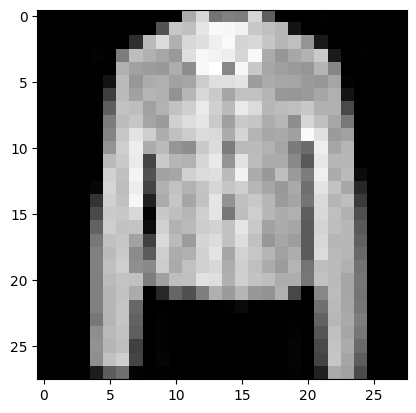

In [25]:
#net.eval()

data_sample = dataset_valid.__getitem__(10)
inp_img, target = [t.to(device) for t in data_sample]
out = net(inp_img.unsqueeze(0))
print(dataset_valid.classes[out.argmax().cpu()])
plt.imshow(inp_img.squeeze().cpu(), cmap='Greys_r')
plt.show()